In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# LDA
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
STOPWORDS = gensim.parsing.preprocessing.STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer('english')

# For viz
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# WordCloud
from wordcloud import WordCloud, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/open_ended_responses.csv")

In [12]:
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

def generate_wordcloud(text):
    text_to_generate = list(text)
    if type(text) == list:
        text_to_generate = " ".join([" ".join(i) for i in text]) if type(text[0]) == list else " ".join(text)
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white').generate(text_to_generate)
    plt.figure(figsize = (13.8, 6))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    
def prepare_lda(text_list):
    preprocessed_text = [preprocess(act) for act in text_list]
    id2word = gensim.corpora.Dictionary(preprocessed_text)
    # Gensim Count Vector
    bow_corpus = [id2word.doc2bow(act) for act in preprocessed_text]
    # for i,c in enumerate(bow_corpus):
    #     if len(c) >= 5:
    #         print("Original sentence:  {}".format(oact[i]))
    #         for i in c:
    #             print("word {} appeared {} times".format(word_dictionary[i[0]], i[1]))
    #         break

    # Convert Count to td-idf score
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    return preprocessed_text, id2word, corpus_tfidf
    
def find_num_topics(num_topic_min, num_topic_max, text, id2word, corpus, verbose = True):
# lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=id2word, passes=2, workers=2)
    coherence_score = []
    for num_topics in range(num_topic_min, num_topic_max + 1):
        lda_model_tfidf = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=id2word, random_state = 100,  
                                                     chunksize=50,passes=50, per_word_topics = True, workers = 5)
        coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=text, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        if verbose:
            print('num_topics = {}   \tCoherence Score:  {}\tPerplexity: {}'.format(num_topics, coherence_lda, lda_model_tfidf.log_perplexity(corpus)))
        coherence_score.append(coherence_lda)
    
    plt.figure(figsize = (13.8, 8))
    sns.set_style('whitegrid')
    plt.plot(list(range(num_topic_min, num_topic_max + 1)), coherence_score, '-o')
    plt.title("Coherence Score vs Num Topics",fontsize=16)
    plt.xlabel("Num Topics", fontsize=14)
    plt.ylabel("Coherence Score", fontsize=14)
    plt.xticks(list(range(num_topic_min, num_topic_max + 1)))
    plt.tick_params(labelsize=14)
    plt.show()
    
    return coherence_score

def check_topics(num_topics, texts, id2word, corpus):
    lda_model_tfidf = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=id2word, 
                                                 random_state = 100,  chunksize=50,
                                                 passes=50, per_word_topics = True, workers = 5)
    coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('num_topics = {} \t Coherence Score:  {} \t Perplexity: {}\n'.format(num_topics, coherence_lda, lda_model_tfidf.log_perplexity(corpus)))
    for idx, topic in lda_model_tfidf.print_topics(-1):
        print('Topics: {} \nWords: {}'.format(idx, topic))
    
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus, id2word)
    return vis

# Other Activities Analysis

In [25]:
oact_col_names = [c for c in df.columns if "oact" in c and "compx" not in c]
oact = [act for c in oact_col_names for act in df[df[c].notnull()].loc[1:, c]]
preprocessed_oact, id2word_oact, corpus_tfidf_oact = prepare_lda(oact)
print("Num of Documents:  ", len(preprocessed_oact))
print("Num of Uniq Words:  ", len(id2word_oact))

Num of Documents:   2293
Num of Uniq Words:   562


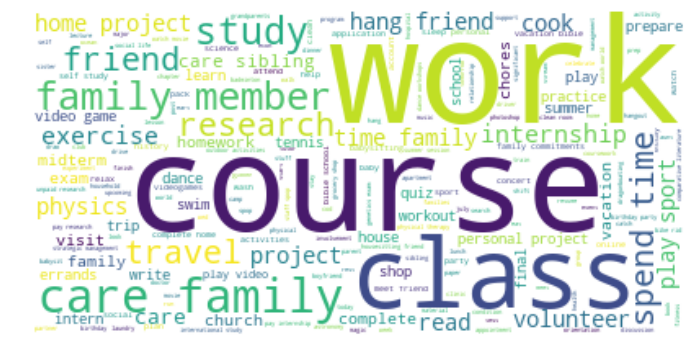

In [7]:
generate_wordcloud(preprocessed_oact)

num_topics = 1   	Coherence Score:  0.7161669799180342	Perplexity: -5.169431365122753
num_topics = 2   	Coherence Score:  0.7115540961481308	Perplexity: -5.33015814502898
num_topics = 3   	Coherence Score:  0.7260311412841869	Perplexity: -5.46810033942975
num_topics = 4   	Coherence Score:  0.7349049148944534	Perplexity: -5.586542470802004
num_topics = 5   	Coherence Score:  0.727458485437017	Perplexity: -5.612064627371428
num_topics = 6   	Coherence Score:  0.7332645919711842	Perplexity: -5.7119316078432885
num_topics = 7   	Coherence Score:  0.735027064104603	Perplexity: -5.761426346871624
num_topics = 8   	Coherence Score:  0.7262546224892967	Perplexity: -5.769487927742252
num_topics = 9   	Coherence Score:  0.7009615452792229	Perplexity: -6.156234475832257
num_topics = 10   	Coherence Score:  0.7117478125901089	Perplexity: -6.211617728435711
num_topics = 11   	Coherence Score:  0.7066111658878362	Perplexity: -6.295656909675377


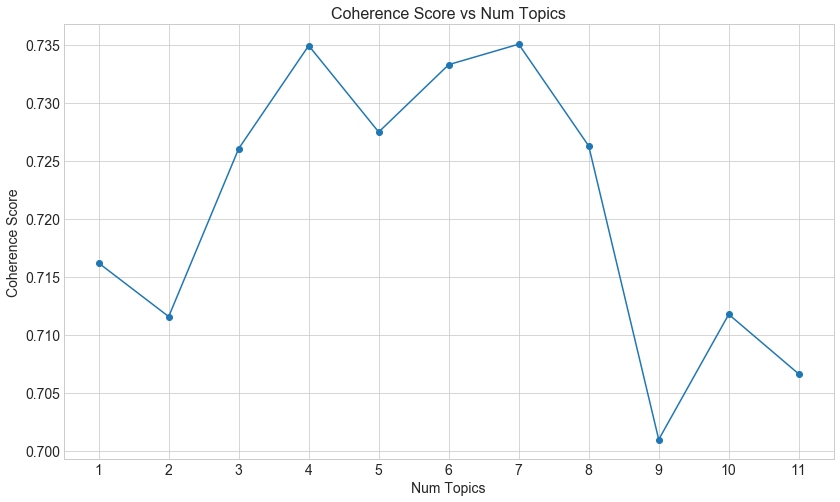

In [8]:
coherence_scores_oact = find_num_topics(1, 11, preprocessed_oact, id2word_oact, corpus_tfidf_oact)

In [14]:
check_topics(3, preprocessed_oact, id2word_oact, corpus_tfidf_oact)

num_topics = 3 	 Coherence Score:  0.7302085992701488 	 Perplexity: -5.468867117039229

Topics: 0 
Words: 0.192*"work" + 0.133*"course" + 0.107*"take" + 0.066*"class" + 0.034*"research" + 0.033*"study" + 0.021*"volunteer" + 0.015*"read" + 0.011*"homework" + 0.011*"shop"
Topics: 1 
Words: 0.049*"project" + 0.049*"friends" + 0.046*"time" + 0.041*"travel" + 0.039*"exercise" + 0.032*"spend" + 0.031*"home" + 0.030*"hang" + 0.026*"cook" + 0.018*"church"
Topics: 2 
Words: 0.111*"family" + 0.071*"care" + 0.045*"internship" + 0.042*"members" + 0.034*"play" + 0.030*"sport" + 0.024*"physics" + 0.021*"personal" + 0.019*"go" + 0.018*"vacation"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.299409  0.009226       1        1  37.957085
1      0.140549 -0.230888       2        1  31.054443
2      0.158860  0.221662       3        1  30.988470, topic_info=    Category        Freq          Term       Total  loglift  logprob
9    Default  208.000000          work  208.000000  30.0000  30.0000
24   Default  144.000000        course  144.000000  29.0000  29.0000
3    Default  115.000000          take  115.000000  28.0000  28.0000
25   Default  100.000000        family  100.000000  27.0000  27.0000
34   Default   62.000000          care   62.000000  26.0000  26.0000
2    Default   72.000000         class   72.000000  25.0000  25.0000
18   Default   43.000000       friends   43.000000  24.0000  24.0000
12   Default   43.000000       project   43.000000  23.0000  23.0000
112  Default   41.000000          time   41.000000  22.0000  22.0000
5    Default   39.000000    internship   39.000000  21.0000  21.0000
74   Default   37.000000       members   37.000000  20.0000  20.0000
141  Default   36.000000        travel   36.000000  19.0000  19.0000
0    Default   34.000000      exercise   34.000000  18.0000  18.0000
21   Default   30.000000          play   30.000000  17.0000  17.0000
13   Default   37.000000      research   37.000000  16.0000  16.0000
145  Default   29.000000         spend   29.000000  15.0000  15.0000
17   Default   35.000000         study   35.000000  14.0000  14.0000
57   Default   27.000000          home   27.000000  13.0000  13.0000
19   Default   27.000000          hang   27.000000  12.0000  12.0000
63   Default   27.000000         sport   27.000000  11.0000  11.0000
10   Default   23.000000          cook   23.000000  10.0000  10.0000
54   Default   22.000000       physics   22.000000   9.0000   9.0000
11   Default   19.000000      personal   19.000000   8.0000   8.0000
35   Default   22.000000     volunteer   22.000000   7.0000   7.0000
200  Default   17.000000            go   17.000000   6.0000   6.0000
234  Default   16.000000        church   16.000000   5.0000   5.0000
133  Default   16.000000      vacation   16.000000   4.0000   4.0000
114  Default   15.000000        chores   15.000000   3.0000   3.0000
61   Default   15.000000      complete   15.000000   2.0000   2.0000
121  Default   14.000000        social   14.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
34    Topic3   62.389351          care   62.946724   1.1627  -2.6501
5     Topic3   39.352509    internship   39.906902   1.1576  -3.1110
74    Topic3   36.992363       members   37.541550   1.1568  -3.1728
21    Topic3   30.115351          play   30.689396   1.1527  -3.3785
63    Topic3   26.581575         sport   27.128593   1.1512  -3.5033
25    Topic3   98.247925        family  100.437332   1.1495  -2.1960
54    Topic3   21.536667       physics   22.094011   1.1460  -3.7138
11    Topic3   18.781906      personal   19.366133   1.1409  -3.8506
200   Topic3   17.065529            go   17.627716   1.1391  -3.9465
133   Topic3   15.629989      vacation   16.178017   1.1371  -4.0343
121   Topic3   13.981842        social   14.528210   1.1332  -4.1458
39    Topic3   13.955302      siblings   14.506788   1.1328  -4.1477
228   Topic3   11.659267       errands   12.207253   1.1256  -4.3274
132   Topic3   11.427525        school   11.982079   1.1242  -4.3475
165   Topic3   11.040402          self   11.602635   1.1219  -4.3820
93    Topic3    9.569446          meet   10.126717   1.1150  -4.5250
111   Topic3    9.380503    management    9.929704   1.1147  -4.5449
83    Topic3    8.832247         dance    9.380179   1.1114  -4.6051
97    Topic3    8.296429         learn    8.867531   1.1050  -4.6677
76    Topic3    7.862790       science    8.409916   1.1043  -4.7214
28    Topic3    7.645482         party    8.192803   1.1024  -4.7494
244   Topic3    7.759073      

In [15]:
check_topics(4, preprocessed_oact, id2word_oact, corpus_tfidf_oact)

num_topics = 4 	 Coherence Score:  0.746163469318496 	 Perplexity: -5.571755076508095

Topics: 0 
Words: 0.193*"course" + 0.155*"take" + 0.097*"class" + 0.050*"research" + 0.046*"study" + 0.031*"volunteer" + 0.016*"homework" + 0.015*"shop" + 0.014*"clean" + 0.014*"quiz"
Topics: 1 
Words: 0.065*"project" + 0.063*"friends" + 0.059*"time" + 0.043*"spend" + 0.040*"home" + 0.039*"hang" + 0.035*"family" + 0.024*"church" + 0.021*"chores" + 0.021*"complete"
Topics: 2 
Words: 0.250*"work" + 0.080*"family" + 0.067*"care" + 0.042*"internship" + 0.041*"travel" + 0.039*"members" + 0.028*"sport" + 0.023*"play" + 0.020*"personal" + 0.018*"go"
Topics: 3 
Words: 0.070*"exercise" + 0.045*"cook" + 0.040*"physics" + 0.034*"read" + 0.026*"intern" + 0.026*"game" + 0.026*"siblings" + 0.019*"final" + 0.018*"video" + 0.017*"watch"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.228123 -0.215439       1        1  28.892931
0     -0.301251 -0.116183       2        1  27.264687
1      0.071555  0.194689       3        1  24.010036
3      0.001573  0.136933       4        1  19.832342, topic_info=    Category        Freq          Term       Total  loglift  logprob
9    Default  206.000000          work  206.000000  30.0000  30.0000
24   Default  150.000000        course  150.000000  29.0000  29.0000
3    Default  121.000000          take  121.000000  28.0000  28.0000
2    Default   76.000000         class   76.000000  27.0000  27.0000
34   Default   55.000000          care   55.000000  26.0000  26.0000
0    Default   40.000000      exercise   40.000000  25.0000  25.0000
12   Default   44.000000       project   44.000000  24.0000  24.0000
18   Default   43.000000       friends   43.000000  23.0000  23.0000
25   Default   90.000000        family   90.000000  22.0000  22.0000
112  Default   41.000000          time   41.000000  21.0000  21.0000
13   Default   39.000000      research   39.000000  20.0000  20.0000
17   Default   36.000000         study   36.000000  19.0000  19.0000
10   Default   26.000000          cook   26.000000  18.0000  18.0000
5    Default   34.000000    internship   34.000000  17.0000  17.0000
145  Default   29.000000         spend   29.000000  16.0000  16.0000
141  Default   34.000000        travel   34.000000  15.0000  15.0000
74   Default   33.000000       members   33.000000  14.0000  14.0000
57   Default   27.000000          home   27.000000  13.0000  13.0000
19   Default   27.000000          hang   27.000000  12.0000  12.0000
54   Default   23.000000       physics   23.000000  11.0000  11.0000
32   Default   20.000000          read   20.000000  10.0000  10.0000
35   Default   24.000000     volunteer   24.000000   9.0000   9.0000
63   Default   23.000000         sport   23.000000   8.0000   8.0000
36   Default   15.000000        intern   15.000000   7.0000   7.0000
20   Default   15.000000          game   15.000000   6.0000   6.0000
39   Default   15.000000      siblings   15.000000   5.0000   5.0000
234  Default   17.000000        church   17.000000   4.0000   4.0000
21   Default   28.000000          play   28.000000   3.0000   3.0000
114  Default   15.000000        chores   15.000000   2.0000   2.0000
61   Default   15.000000      complete   15.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
10    Topic4   25.408722          cook   26.025017   1.5939  -3.1021
54    Topic4   22.635386       physics   23.251801   1.5910  -3.2177
32    Topic4   19.466911          read   20.081419   1.5868  -3.3685
36    Topic4   14.798189        intern   15.411089   1.5773  -3.6427
20    Topic4   14.427733          game   15.041635   1.5762  -3.6681
39    Topic4   14.426249      siblings   15.044139   1.5759  -3.6682
22    Topic4   10.400421         video   11.013411   1.5606  -3.9954
240   Topic4   10.493052         final   11.119032   1.5599  -3.9865
37    Topic4    9.831313         watch   10.444588   1.5573  -4.0517
93    Topic4    9.677551          meet   10.295053   1.5560  -4.0674
191   Topic4    8.609846    activities    9.230568   1.5482  -4.1843
460   Topic4    7.681346       fitness    8.294500   1.5411  -4.2984
85    Topic4    7.643681        friend    8.263454   1.5399  -4.3033
41    Topic4    7.243464       history    7.861248   1.5360  -4.3571
104   Topic4    6.534991    videogames    7.147909   1.5282  -4.4601
101   Topic4    6.239486         relax    6.852721   1.5241  -4.5063
38    Topic4    6.223403         world    6.836275   1.5239  -4.5089
176   Topic4    5.622304        stream    6.235307   1.5144  -4.6105
103   Topic4    5.614136         movie    6.231812   1.5135  -4.6119
86    Topic4    5.507643  housesitting    6.120399   1.5124  -4.6311
180   Topic4    5.443946        resume    6.0

# Course-related activities Analysis

In [24]:
cact_col_names = ["dcact{}".format(i) for i in range(1, 31)]
cact = [act for c in cact_col_names for act in df[df[c].notnull()].loc[1:, c]]
preprocessed_cact, id2word_cact, corpus_tfidf_cact = prepare_lda(cact)
print("Num of Documents:  ", len(preprocessed_cact))
print("Num of Uniq Words:  ", len(id2word_cact))

Num of Documents:   805
Num of Uniq Words:   121


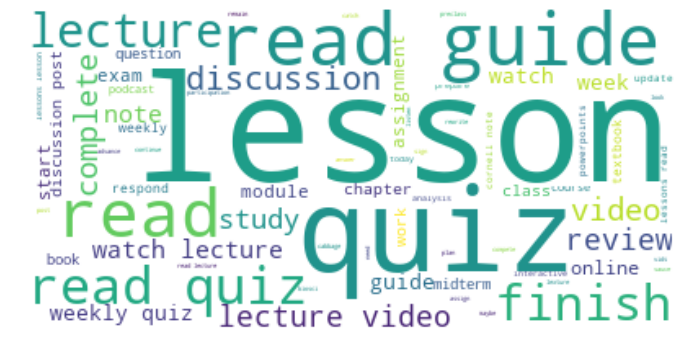

In [21]:
generate_wordcloud(preprocessed_cact)

num_topics = 1   	Coherence Score:  0.5125173806583482	Perplexity: -3.6666679019294737
num_topics = 2   	Coherence Score:  0.6332385624073158	Perplexity: -3.829212689154659
num_topics = 3   	Coherence Score:  0.6669920654846871	Perplexity: -4.016798288551434
num_topics = 4   	Coherence Score:  0.6972662160433558	Perplexity: -4.159457990291891
num_topics = 5   	Coherence Score:  0.6991622331390838	Perplexity: -4.284081622375883
num_topics = 6   	Coherence Score:  0.7107111013931995	Perplexity: -4.338994592616852
num_topics = 7   	Coherence Score:  0.7071766146699671	Perplexity: -4.432387880799961
num_topics = 8   	Coherence Score:  0.6646694866614937	Perplexity: -4.424778285766069
num_topics = 9   	Coherence Score:  0.6722847280097706	Perplexity: -4.551703716711198
num_topics = 10   	Coherence Score:  0.6635476852651434	Perplexity: -4.60503155032388
num_topics = 11   	Coherence Score:  0.6603787063484498	Perplexity: -4.671522145009486


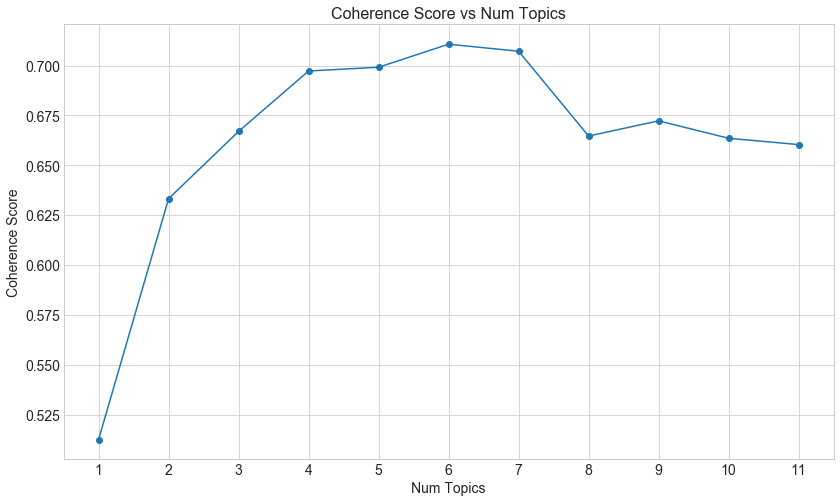

In [17]:
coherence_scores_cact = find_num_topics(1, 11, preprocessed_cact, id2word_cact, corpus_tfidf_cact)

In [19]:
check_topics(4, preprocessed_cact, id2word_cact, corpus_tfidf_cact)

num_topics = 4 	 Coherence Score:  0.7053086934454558 	 Perplexity: -4.156008820439194

Topics: 0 
Words: 0.242*"lecture" + 0.101*"weekly" + 0.099*"video" + 0.088*"videos" + 0.081*"watch" + 0.054*"lesson" + 0.040*"lessons" + 0.039*"online" + 0.039*"finish" + 0.030*"assignments"
Topics: 1 
Words: 0.276*"quiz" + 0.221*"read" + 0.136*"lesson" + 0.076*"review" + 0.063*"complete" + 0.044*"week" + 0.041*"finish" + 0.020*"discussions" + 0.011*"take" + 0.011*"book"
Topics: 2 
Words: 0.355*"guide" + 0.115*"note" + 0.112*"read" + 0.054*"exam" + 0.022*"update" + 0.022*"cornell" + 0.019*"analysis" + 0.017*"powerpoints" + 0.015*"film" + 0.011*"rewrite"
Topics: 3 
Words: 0.197*"discussion" + 0.148*"study" + 0.056*"module" + 0.048*"post" + 0.047*"lesson" + 0.044*"start" + 0.036*"midterm" + 0.032*"class" + 0.030*"finish" + 0.029*"podcast"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.146232 -0.160441       1        1  34.479828
0      0.285017 -0.138934       2        1  26.725212
2     -0.217872  0.025389       3        1  19.611792
3      0.079087  0.273986       4        1  19.183168, topic_info=    Category        Freq         Term       Total  loglift  logprob
6    Default   75.000000        guide   75.000000  30.0000  30.0000
2    Default  103.000000         quiz  103.000000  29.0000  29.0000
19   Default   70.000000      lecture   70.000000  28.0000  28.0000
26   Default   41.000000   discussion   41.000000  27.0000  27.0000
4    Default  106.000000         read  106.000000  26.0000  26.0000
8    Default   31.000000        study   31.000000  25.0000  25.0000
29   Default   25.000000         note   25.000000  24.0000  24.0000
40   Default   29.000000       weekly   29.000000  23.0000  23.0000
45   Default   29.000000        video   29.000000  22.0000  22.0000
31   Default   26.000000       videos   26.000000  21.0000  21.0000
20   Default   24.000000        watch   24.000000  20.0000  20.0000
21   Default   29.000000       review   29.000000  19.0000  19.0000
11   Default   24.000000     complete   24.000000  18.0000  18.0000
5    Default   76.000000       lesson   76.000000  17.0000  17.0000
25   Default   12.000000       module   12.000000  16.0000  16.0000
12   Default   12.000000         exam   12.000000  15.0000  15.0000
63   Default   10.000000         post   10.000000  14.0000  14.0000
39   Default    9.000000        start    9.000000  13.0000  13.0000
49   Default   17.000000         week   17.000000  12.0000  12.0000
53   Default   12.000000      lessons   12.000000  11.0000  11.0000
42   Default   12.000000       online   12.000000  10.0000  10.0000
0    Default    8.000000      midterm    8.000000   9.0000   9.0000
1    Default    7.000000        class    7.000000   8.0000   8.0000
9    Default    9.000000  assignments    9.000000   7.0000   7.0000
46   Default    6.000000      podcast    6.000000   6.0000   6.0000
60   Default    5.000000     question    5.000000   5.0000   5.0000
89   Default    5.000000      cornell    5.000000   4.0000   4.0000
90   Default    5.000000       update    5.000000   3.0000   3.0000
17   Default   33.000000       finish   33.000000   2.0000   2.0000
71   Default    4.000000     analysis    4.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
25    Topic4   11.664335       module   12.361800   1.5931  -2.8782
63    Topic4    9.918462         post   10.615417   1.5832  -3.0404
39    Topic4    9.065642        start    9.769958   1.5763  -3.1303
0     Topic4    7.473759      midterm    8.170509   1.5620  -3.3234
1     Topic4    6.704606        class    7.404593   1.5518  -3.4320
46    Topic4    6.044565      podcast    6.751079   1.5406  -3.5356
60    Topic4    4.850992     question    5.549249   1.5167  -3.7556
95    Topic4    3.818684         plan    4.517422   1.4831  -3.9949
64    Topic4    3.805747      respond    4.503748   1.4827  -3.9983
117   Topic4    3.270038    guideline    3.966665   1.4580  -4.1500
68    Topic4    2.864784  interactive    3.563253   1.4330  -4.2823
118   Topic4    2.636146  participate    3.335435   1.4159  -4.3654
111   Topic4    2.519353         sign    3.215891   1.4070  -4.4108
107   Topic4    2.158790     continue    2.855322   1.3715  -4.5652
84    Topic4    1.930497         vids    2.627080   1.3430  -4.6770
93    Topic4    1.769718       remain    2.471101   1.3173  -4.7639
61    Topic4    1.675599       listen    2.373986   1.3027  -4.8186
24    Topic4    1.395498   assignment    2.093570   1.2455  -5.0015
59    Topic4    1.346805       answer    2.043684   1.2341  -5.0370
100   Topic4    1.152157     revision    1.848950   1.1782  -5.1931
106   Topic4    1.152157      levture    1.848950   1.1782  -5.1931
96    Topic4    1.145928   ph

In [22]:
check_topics(5, preprocessed_cact, id2word_cact, corpus_tfidf_cact)

num_topics = 5 	 Coherence Score:  0.6954681107134991 	 Perplexity: -4.259661904315921

Topics: 0 
Words: 0.257*"lecture" + 0.217*"quiz" + 0.124*"video" + 0.114*"weekly" + 0.049*"watch" + 0.048*"lesson" + 0.015*"advance" + 0.012*"analysis" + 0.011*"prepare" + 0.010*"rewatch"
Topics: 1 
Words: 0.288*"read" + 0.150*"quiz" + 0.148*"guide" + 0.146*"lesson" + 0.078*"review" + 0.071*"finish" + 0.013*"take" + 0.012*"book" + 0.012*"textbook" + 0.005*"maybe"
Topics: 2 
Words: 0.153*"note" + 0.141*"week" + 0.100*"lessons" + 0.100*"online" + 0.066*"exam" + 0.047*"watch" + 0.044*"work" + 0.041*"podcast" + 0.027*"cornell" + 0.027*"update"
Topics: 3 
Words: 0.211*"discussion" + 0.157*"study" + 0.060*"module" + 0.052*"post" + 0.046*"start" + 0.046*"lesson" + 0.040*"finish" + 0.036*"midterm" + 0.034*"class" + 0.026*"course"
Topics: 4 
Words: 0.203*"videos" + 0.190*"complete" + 0.086*"lecture" + 0.068*"assignments" + 0.062*"discussions" + 0.062*"watch" + 0.046*"lesson" + 0.043*"chapter" + 0.021*"powerp

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.280831 -0.091819       1        1  32.866753
0      0.135332  0.186393       2        1  20.078135
3     -0.069264 -0.280083       3        1  16.842339
4     -0.076509  0.161546       4        1  15.797067
2     -0.270390  0.023963       5        1  14.415714, topic_info=    Category        Freq         Term       Total  loglift  logprob
4    Default  103.000000         read  103.000000  30.0000  30.0000
19   Default   70.000000      lecture   70.000000  29.0000  29.0000
2    Default  101.000000         quiz  101.000000  28.0000  28.0000
26   Default   39.000000   discussion   39.000000  27.0000  27.0000
31   Default   35.000000       videos   35.000000  26.0000  26.0000
11   Default   33.000000     complete   33.000000  25.0000  25.0000
6    Default   53.000000        guide   53.000000  24.0000  24.0000
8    Default   29.000000        study   29.000000  23.0000  23.0000
29   Default   24.000000         note   24.000000  22.0000  22.0000
49   Default   22.000000         week   22.000000  21.0000  21.0000
45   Default   27.000000        video   27.000000  20.0000  20.0000
40   Default   25.000000       weekly   25.000000  19.0000  19.0000
53   Default   16.000000      lessons   16.000000  18.0000  18.0000
42   Default   16.000000       online   16.000000  17.0000  17.0000
21   Default   28.000000       review   28.000000  16.0000  16.0000
9    Default   12.000000  assignments   12.000000  15.0000  15.0000
20   Default   28.000000        watch   28.000000  14.0000  14.0000
17   Default   33.000000       finish   33.000000  13.0000  13.0000
12   Default   11.000000         exam   11.000000  12.0000  12.0000
41   Default   11.000000  discussions   11.000000  11.0000  11.0000
25   Default   11.000000       module   11.000000  10.0000  10.0000
63   Default   10.000000         post   10.000000   9.0000   9.0000
5    Default   78.000000       lesson   78.000000   8.0000   8.0000
39   Default    9.000000        start    9.000000   7.0000   7.0000
15   Default    7.000000         work    7.000000   6.0000   6.0000
3    Default    7.000000      chapter    7.000000   5.0000   5.0000
46   Default    7.000000      podcast    7.000000   4.0000   4.0000
0    Default    7.000000      midterm    7.000000   3.0000   3.0000
1    Default    6.000000        class    6.000000   2.0000   2.0000
89   Default    4.000000      cornell    4.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
15    Topic5    6.845179         work    7.574725   1.8356  -3.1255
46    Topic5    6.430039      podcast    7.159188   1.8294  -3.1881
89    Topic5    4.257120      cornell    4.985994   1.7788  -3.6005
90    Topic5    4.257120       update    4.985994   1.7788  -3.6005
13    Topic5    2.176588        today    2.908402   1.6470  -4.2713
51    Topic5    1.673310         look    2.407633   1.5730  -4.5342
35    Topic5    1.458727       biosci    2.188783   1.5311  -4.6715
101   Topic5    1.294564         math    2.023517   1.4902  -4.7909
104   Topic5    1.294564          run    2.023517   1.4902  -4.7909
82    Topic5    1.194510        forum    1.923461   1.4605  -4.8713
76    Topic5    1.108060         term    1.837770   1.4309  -4.9464
102   Topic5    1.101917     material    1.831265   1.4289  -4.9520
103   Topic5    1.078732        weeks    1.808066   1.4204  -4.9733
22    Topic5    1.015679      biology    1.744629   1.3959  -5.0335
108   Topic5    0.998370   activities    1.728807   1.3878  -5.0507
38    Topic5    0.972670         fill    1.702408   1.3771  -5.0768
16    Topic5    0.897690  preparation    1.626605   1.3424  -5.1570
67    Topic5    0.831151  everythingâ    1.560066   1.3072  -5.2340
36    Topic5    0.813173   coursework    1.542090   1.2969  -5.2559
20    Topic5    7.371796        watch   28.935074   0.5695  -3.0514
116   Topic5    0.222819         test    1.

In [20]:
check_topics(6, preprocessed_cact, id2word_cact, corpus_tfidf_cact)

num_topics = 6 	 Coherence Score:  0.7127091881443279 	 Perplexity: -4.3266895453189536

Topics: 0 
Words: 0.305*"lecture" + 0.154*"weekly" + 0.148*"video" + 0.072*"quiz" + 0.066*"watch" + 0.056*"lesson" + 0.055*"finish" + 0.008*"today" + 0.008*"catch" + 0.007*"maybe"
Topics: 1 
Words: 0.360*"quiz" + 0.296*"read" + 0.145*"lesson" + 0.062*"finish" + 0.024*"week" + 0.016*"book" + 0.014*"textbook" + 0.004*"church" + 0.003*"guidance" + 0.003*"material"
Topics: 2 
Words: 0.318*"guide" + 0.148*"read" + 0.091*"lesson" + 0.069*"online" + 0.069*"lessons" + 0.050*"exam" + 0.045*"complete" + 0.032*"chapter" + 0.030*"podcast" + 0.009*"continue"
Topics: 3 
Words: 0.233*"discussion" + 0.173*"study" + 0.066*"module" + 0.058*"post" + 0.053*"lesson" + 0.048*"start" + 0.040*"midterm" + 0.038*"class" + 0.034*"finish" + 0.024*"plan"
Topics: 4 
Words: 0.196*"videos" + 0.130*"complete" + 0.082*"week" + 0.080*"lecture" + 0.079*"watch" + 0.067*"assignments" + 0.061*"discussions" + 0.043*"lesson" + 0.023*"anal

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.231149 -0.092917       1        1  23.199800
2     -0.127722 -0.220150       2        1  18.464119
0     -0.091625  0.246475       3        1  17.215626
3      0.106178 -0.044826       4        1  14.605765
4      0.018793  0.190794       5        1  14.514133
5      0.325524 -0.079375       6        1  12.000550, topic_info=    Category        Freq            Term       Total  loglift  logprob
2    Default  104.000000            quiz  104.000000  30.0000  30.0000
6    Default   64.000000           guide   64.000000  29.0000  29.0000
4    Default  104.000000            read  104.000000  28.0000  28.0000
19   Default   69.000000         lecture   69.000000  27.0000  27.0000
21   Default   38.000000          review   38.000000  26.0000  26.0000
26   Default   37.000000      discussion   37.000000  25.0000  25.0000
31   Default   31.000000          videos   31.000000  24.0000  24.0000
8    Default   28.000000           study   28.000000  23.0000  23.0000
40   Default   29.000000          weekly   29.000000  22.0000  22.0000
29   Default   23.000000            note   23.000000  21.0000  21.0000
45   Default   28.000000           video   28.000000  20.0000  20.0000
11   Default   29.000000        complete   29.000000  19.0000  19.0000
20   Default   25.000000           watch   25.000000  18.0000  18.0000
49   Default   19.000000            week   19.000000  17.0000  17.0000
42   Default   14.000000          online   14.000000  16.0000  16.0000
53   Default   14.000000         lessons   14.000000  15.0000  15.0000
9    Default   11.000000     assignments   11.000000  14.0000  14.0000
25   Default   11.000000          module   11.000000  13.0000  13.0000
41   Default   10.000000     discussions   10.000000  12.0000  12.0000
17   Default   31.000000          finish   31.000000  11.0000  11.0000
63   Default    9.000000            post    9.000000  10.0000  10.0000
12   Default   10.000000            exam   10.000000   9.0000   9.0000
39   Default    8.000000           start    8.000000   8.0000   8.0000
5    Default   80.000000          lesson   80.000000   7.0000   7.0000
15   Default    7.000000            work    7.000000   6.0000   6.0000
47   Default    6.000000            take    6.000000   5.0000   5.0000
0    Default    7.000000         midterm    7.000000   4.0000   4.0000
1    Default    6.000000           class    6.000000   3.0000   3.0000
110  Default    5.000000         advance    5.000000   2.0000   2.0000
14   Default    5.000000          course    5.000000   1.0000   1.0000
..       ...         ...             ...         ...      ...      ...
68    Topic6    2.811891     interactive    3.558755   1.8847  -3.8318
77    Topic6    2.736530         prepare    3.483668   1.8788  -3.8590
93    Topic6    1.853709          remain    2.601167   1.7814  -4.2485
74    Topic6    1.783499          assign    2.530556   1.7704  -4.2871
106   Topic6    1.178609         levture    1.925346   1.6294  -4.7013
104   Topic6    1.178609             run    1.925346   1.6294  -4.7013
92    Topic6    1.152600            econ    1.899338   1.6207  -4.7237
82    Topic6    1.086465           forum    1.833202   1.5971  -4.7828
70    Topic6    0.994017           cideo    1.740757   1.5599  -4.8717
65    Topic6    0.877898  participations    1.624826   1.5046  -4.9959
69    Topic6    0.865492      yesterdayâ    1.612613   1.4979  -5.0101
28    Topic6    0.863626        entirety    1.610752   1.4969  -5.0123
116   Topic6    0.180185            test    1.224140   0.2042  -6.5795
114   Topic6    0.180185           juice    1.224140   0.2042  -6.5795
115   Topic6    0.180185         perform    1.224140   0.2042  -6.5795
67    Topic6    0.180188     everythingâ    1.340573   0.1134  -6.5794
33    Topic6    0.180186           grade    1.370751   0.0911  -6.5795
32    Topic6    0.180186           check    1.